# Guide for Analyzing Polymarket Convergence

## 1. Set Up Your Parameters

- **`COLUMN_NAMES_TO_PICK`**  
  - If you set this to `None`, the notebook will pull **all** markets in the event.  
  - Otherwise, supply a Python list of the exact market titles you care about, e.g.:  
    ```python
    COLUMN_NAMES_TO_PICK = [
      "Will Donald Trump win the 2024 US Presidential Election?",
      "Will Joe Biden win the 2024 US Presidential Election?"
    ]
    ```
- **`W`** (rolling-window size)  
  - Number of consecutive snapshots over which to measure belief-dispersion.  
  - Smaller `W` (e.g. 10–20) reacts faster to jumps; larger `W` (50–100) smooths more.
- **`FIDELITY`**  
  - Seconds between price samples.  
  - Default `720` means “twice per day.” You can increase (e.g. `3600*4` for every 4 h) or decrease (e.g. `3600` for hourly).
- **`EVENT_URL`**  
  - Copy-paste the Polymarket event page you want to analyze, e.g.:  
    ```python
    EVENT_URL = "https://polymarket.com/event/poland-presidential-election"
    ```

> Make sure these four are defined at the top of your notebook before fetching any data.

---

## 2. What Data You’ll Produce

For each selected market, you’ll compute:

- **`b_i`** — the _implied belief_ behind each price move.  
- **`delta_b_roll(i)`** — the belief-spread over the last `W` snapshots.  
- **`I_{0.02}`** — how many trades until the rolling spread first goes below 2% (or `None` if it never does).  
- **`i_{1/2}`** — how many trades until that spread falls to half its first non-zero value (or `None`).  
- **`λ`** — the per-trade decay rate from fitting  
  \[
    \ln(\Delta b_{\rm roll}) \;=\; \alpha \;-\; \lambda\,i.
  \]
- **`R^2`** — how well that exponential-decay model fits.

You’ll end up with a summary table like:

| market                        | I_delta | time_I_delta        | i_half | time_half           | lambda  | R²    |
|-------------------------------|---------|---------------------|--------|---------------------|---------|-------|
| “Will Trump win 2024?”        | 132     | 2024-03-13 00:00:03 | 85     | 2024-02-28 12:00:03 | 0.00054 | 0.03  |
| “Will Biden win 2024?”        | None    | None                | None   | None                | 0.00034 | 0.02  |
| …                             | …       | …                   | …      | …                   | …       | …     |

- **`None`** in `I_delta` or `i_half` means the market never tightened enough (did not converge).  
- A **small `λ`** and low `R²` means the spread does _not_ follow a clean exponential decay.

---

## 3. How to Interpret

- **Fast vs Slow Convergence**  
  - **Fast**: small `I_delta` and small `i_half`.  
  - **Slow (or none)**: large or `None` values.
- **Exponential Fit**  
  - If `λ > 0` and `R² > 0.5`, the market roughly follows \(\Delta b \sim e^{-λ i}\).  
  - If `R²` is low, the decay is too noisy or non-exponential—try other methods (below).


Here the decay is not really a good measure as for the data I have used it did never fit (so I guess we can skip it and use AUC (Area under curve) instead. We can also maybe try to change the fitting method, but tbh I spent so much time already on this so I don't have time anymore with the other projects and finals anymore 😭😭😭
---

## 4. Next Steps & Extensions

Most importnat:
**Aggregate & Compare**  
   - Normalize each market’s spread by its first nonzero value and re-scale \(i\) to \([0,1]\).  
   - Average across markets to produce an **overall convergence curve**.  
   - Tabulate what fraction of markets hit each threshold by given trade counts or time.

**Interpret & Report**  
   - Identify “fast‐converging” vs “slow‐converging” markets.  
   - Link spikes or slowdowns to real‐world events (debates, primaries).  
   - Note where exponential decay fails—suggest alternative measures.  

Some additional thinkgs:

1. **Check Robustness**  
   - Vary `W` (try 10, 20, 50) and see if markets’ rankings by `i_half` stay consistent.  
   - Vary `FIDELITY` (hourly vs twice-daily) to test sampling sensitivity. I have use 720 and I guess this is fine (measures 2 a day)

2. **Additional Convergence Measures**  
- **AUC**: total area under the $$\Delta b_{\rm roll}(i)$$ curve  
  $$
    \text{AUC} \;=\; \int_{i_0}^{i_{\max}} \Delta b_{\rm roll}(i)\,di
  $$  
  Smaller AUC means faster overall convergence.

- **Power-Law Fit**: assume  
  $$
    \Delta b(i)\approx C\,i^{-\beta}
  $$  
  then estimate $$\beta$$ by regressing  
  $$
    \ln\bigl(\Delta b(i)\bigr)\quad\text{vs.}\quad\ln(i)\,.
  $$  
  A larger $$\beta$$ indicates stronger “long-tail” decay.

- **Segment-Slopes**: split each market’s sequence into _early_, _mid_, _late_ thirds (by index), then within each segment fit  
  $$
    \ln\bigl(\Delta b(i)\bigr) \;=\;\alpha - \lambda\,i
    \quad\text{or}\quad
    \Delta b(i) \;=\; a + b\,i
  $$  
  to get local slopes $$\lambda$$ or $$b$$.  Comparing slopes shows when convergence is fastest.
3. **Event Overlays**  
   - Identify key dates (debates, primaries).  
   - On your $$\Delta b_{\rm roll}(t)$$ vs. time plots, add vertical lines at those timestamps to see which events spark spikes in belief‐dispersion.

4. **Cross-Market Aggregation**  
   - **Normalized spread**  
     $$
     \tilde{\Delta b}(i)
     = \frac{\Delta b_{\rm roll}(i)}{\Delta b_{\rm roll}(i_0)}
     $$  
     where `i₀` is the first snapshot index with non-zero spread.  
   - **Fraction-through-lifetime**  
     $$
     \tau
     = \frac{i - i_{0}}{i_{\max} - i_{0}}
     \quad\in\;[0,1],
     $$
     where `i_max` is the last snapshot index for that market.  
   - Bin τ (e.g. into 20 equal intervals) and compute the **average** of  
     `\tilde{\Delta b}(i)` in each bin across markets to get a single  
     “average convergence curve” over normalized time.
5. **Literature & Validation**  
   - **Aumann (1976)**: formal _Agreeing to Disagree_ theorem under Bayesian‐rational trading.  
   - **Wolfers & Zitzewitz (2004)** and **Berg et al. (2008)**: empirical convergence speeds in election markets.  
   - **Comparison**: contrast your Polymarket \(\lambda\) and \(\beta\) estimates with those papers—note whether Polymarket converges faster, slower, or differently, and discuss possible reasons (liquidity, event frequency, market design).


# CLOB API - Simple plotting 2 markets

# Getting trades:

In [ ]:
import requests
import pandas as pd

def get_trades(market_id):
    """
    Returns a DataFrame where each row is a single trade,
    with columns: ['timestamp', 'p_before', 'p_after', 'volume', 'direction'].
    """
    url = f"https://data-api.polymarket.com/trades?market={market_id}"
    resp = requests.get(url)
    payload = resp.json()
    # data = resp.json()['data']   # adapt to actual JSON structure

    # # Normalize into DataFrame
    # df = pd.json_normalize(data)
    # # Suppose JSON fields are: 't' (unix sec), 'p_before', 'p_after', 'size', 'side'
    # df = df.rename(columns={
    #     't': 'timestamp',
    #     'p_before': 'p_before',
    #     'p_after': 'p_after',
    #     'size': 'volume',
    #     'side': 'direction'
    # })
    # # Convert timestamp to pandas datetime
    # df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    # # Sort by time in case API returns out of order
    # df = df.sort_values('timestamp').reset_index(drop=True)
    return payload[:3]

In [ ]:
url = "https://data-api.polymarket.com/trades?market=0xdd22472e552920b8438158ea7238bfadfa4f736aa4cee91a6b86c39ead110917&limit=10000"
resp = requests.get(url)
payload = resp.json()
print(payload[0]['timestamp'])
print(payload[-1]['timestamp'])
print(len(payload))


1730906255
1730877035
10000


In [ ]:
get_trades("0xdd22472e552920b8438158ea7238bfadfa4f736aa4cee91a6b86c39ead110917")

[{'proxyWallet': '0x08d8da980a7002795bf8bb31f42cabee719e8f54',
  'side': 'SELL',
  'asset': '21742633143463906290569050155826241533067272736897614950488156847949938836455',
  'conditionId': '0xdd22472e552920b8438158ea7238bfadfa4f736aa4cee91a6b86c39ead110917',
  'size': 351.11,
  'price': 0.997,
  'timestamp': 1730906255,
  'title': 'Will Donald Trump win the 2024 US Presidential Election?',
  'slug': 'will-donald-trump-win-the-2024-us-presidential-election',
  'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/will-donald-trump-win-the-2024-us-presidential-election-c83f01bb-5089-4222-9347-3f12673b6a48.png',
  'eventSlug': 'presidential-election-winner-2024',
  'outcome': 'Yes',
  'outcomeIndex': 0,
  'name': 'Arthes86',
  'pseudonym': 'Pretty-Littleneck',
  'bio': '',
  'profileImage': '',
  'profileImageOptimized': '',
  'transactionHash': '0xcfaa467fd697e4d9b2e1a47df496809489b820a871dff56f869fcf1a59add863'},
 {'proxyWallet': '0x7e86bfcd9b00d970fd290a24feef255436d54d7e',
  

# Extracting important data from events (link of the event)
Here event is a set of markets (e.g. presidentail election winner (event): has markets: (will trump win yes/no) (will kamala win yes/no) etc.)

In [ ]:
import requests
import json
from urllib.parse import urlparse

def extract_slug_from_event_url(event_url: str) -> str:
    """
    Given a Polymarket “/event/…” URL (possibly with a ?tid=… query),
    return just the slug part (e.g. "presidential-election-winner-2024").
    """
    parsed = urlparse(event_url)
    # parsed.path might be "/event/presidential-election-winner-2024"
    parts = parsed.path.strip("/").split("/")
    if len(parts) < 2 or parts[0] != "event":
        raise ValueError(f"URL does not look like a Polymarket /event/: {event_url!r}")
    return parts[1]


def fetch_and_print_clob_token_ids_from_url(event_url: str):
    # 1) Extract slug from the full URL
    slug = extract_slug_from_event_url(event_url)

    # 2) Fetch from gamma‑api using that slug
    api_url = f"https://gamma-api.polymarket.com/events?slug={slug}"
    resp = requests.get(api_url)
    resp.raise_for_status()


    data = resp.json()
    print(data)
    if not data:
        raise RuntimeError(f"No event found for slug '{slug}'")

    markets = data[0].get("markets", [])
    if not markets:
        print("  No markets returned in this event.")
        return

    # 3) Loop over each market and parse its clobTokenIds (which come back as a JSON‐string)
    for market in markets:
        question = market.get("question", "<no question>")
        raw_clob_ids = market.get("clobTokenIds", "[]")  # still a string like '["id1","id2"]'
        condition_id = market.get("conditionId")
        try:
            clob_list = json.loads(raw_clob_ids)
        except json.JSONDecodeError:
            clob_list = []  # fallback if something unexpected appears

        first_token = clob_list[0] if len(clob_list) > 0 else None
        print(f"Market question: {question}")
        print("  Parsed clobTokenIds:", clob_list)
        print("  First token ID (Used for price tracking)  :", first_token)
        print("  Market ID  (Used for getting the trades)  :", condition_id)

        print("--------------------------------------------------")

In [ ]:
fetch_and_print_clob_token_ids_from_url("https://polymarket.com/event/who-will-win-dem-nomination-for-nyc-mayor?tid=1749021182749")

[{'id': '16111', 'ticker': 'who-will-win-dem-nomination-for-nyc-mayor', 'slug': 'who-will-win-dem-nomination-for-nyc-mayor', 'title': 'Who will win Dem nomination for NYC Mayor?', 'description': 'This is a market on predicting the winner of the Democratic nomination for New York City Mayor.', 'resolutionSource': '', 'startDate': '2024-12-30T15:49:49.006414Z', 'creationDate': '2024-12-30T15:49:49.006405Z', 'endDate': '2025-06-24T12:00:00Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/who-will-win-dem-nomination-for-nyc-mayor-PN5445mq0qPS.png', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/who-will-win-dem-nomination-for-nyc-mayor-PN5445mq0qPS.png', 'active': True, 'closed': False, 'archived': False, 'new': False, 'featured': True, 'restricted': True, 'liquidity': 2595423.09993, 'volume': 18565291.298514, 'openInterest': 0, 'sortBy': 'price', 'createdAt': '2024-12-29T18:54:00.212327Z', 'updatedAt': '2025-06-08T13:48:20.870943Z', 'competitive': 0.9097318

In [ ]:

resp = requests.get('https://gamma-api.polymarket.com/events?slug=who-will-win-dem-nomination-for-nyc-mayor')
markets = resp.json()[0]['markets']
print(resp.json()[0]['markets'])
for market in markets:
  clob_ids = market['clobTokenIds']
  print(clob_ids)
  print(f"Market question: {market['question'][:20]}, --- To view the prices: {clob_ids} --- for the trades: {(market['clobTokenIds'])}")


[{'id': '516805', 'question': 'Will Person G win the Democratic Primary for Mayor of New York City?', 'conditionId': '0xa00b2359e6bc93910c99d697b859a5e510297e597f0d06ad739e1e224feef31f', 'slug': 'will-person-g-win-the-democratic-primary-for-mayor-of-new-york-city', 'resolutionSource': '', 'endDate': '2025-06-24T12:00:00Z', 'liquidity': '0', 'startDate': '2024-12-30T15:56:43.931368Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/will-andrew-yang-win-the-democratic-primary-for-mayor-of-new-york-city-_ZIta9xJkkGU.jpg', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/will-andrew-yang-win-the-democratic-primary-for-mayor-of-new-york-city-_ZIta9xJkkGU.jpg', 'description': 'The Democratic Primary for Mayor of New York City is scheduled for June 24, 2025.  \n\nThis market will resolve to “Yes” if Person G wins the 2025 Democratic Primary for Mayor of New York City. Otherwise, this market will resolve to “No”.\n\nThis market may be updated in the future to replac

In [ ]:
print(resp.json())

[{'id': '16111', 'ticker': 'who-will-win-dem-nomination-for-nyc-mayor', 'slug': 'who-will-win-dem-nomination-for-nyc-mayor', 'title': 'Who will win Dem nomination for NYC Mayor?', 'description': 'This is a market on predicting the winner of the Democratic nomination for New York City Mayor.', 'resolutionSource': '', 'startDate': '2024-12-30T15:49:49.006414Z', 'creationDate': '2024-12-30T15:49:49.006405Z', 'endDate': '2025-06-24T12:00:00Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/who-will-win-dem-nomination-for-nyc-mayor-PN5445mq0qPS.png', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/who-will-win-dem-nomination-for-nyc-mayor-PN5445mq0qPS.png', 'active': True, 'closed': False, 'archived': False, 'new': False, 'featured': True, 'restricted': True, 'liquidity': 2595423.09993, 'volume': 18565291.298514, 'openInterest': 0, 'sortBy': 'price', 'createdAt': '2024-12-29T18:54:00.212327Z', 'updatedAt': '2025-06-08T13:48:20.870943Z', 'competitive': 0.9097318

# Extracting the data from link (to get the prices)

In [ ]:
import requests
import json
from urllib.parse import urlparse
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timezone

In [ ]:
def get_prices(market_id, fidelity):
  url       = "https://clob.polymarket.com/prices-history"
  params    = {
      "interval": "all",     # full history
      "market":   market_id,
      "fidelity": fidelity
  }

  # 2. Fetch JSON
  resp = requests.get(url, params=params)
  resp.raise_for_status()
  data = resp.json()

  return data

In [ ]:
def extract_slug_from_event_url(event_url: str) -> str:
    """
    Given a Polymarket “/event/…” URL (possibly with query parameters), return just the slug part.
    Example: "https://polymarket.com/event/presidential-election-winner-2024?tid=abc123"
             → "presidential-election-winner-2024"
    Raises ValueError if the URL path does not look like /event/<slug>.
    """
    parsed = urlparse(event_url)
    parts = parsed.path.strip("/").split("/")
    if len(parts) < 2 or parts[0] != "event":
        raise ValueError(f"URL does not look like a Polymarket /event/ URL: {event_url!r}")
    return parts[1]


In [ ]:
def fetch_markets_from_slug(slug: str) -> list:
    """
    Fetch the event data from Polymarket’s Gamma API using the slug, then return the list of markets.
    Each market is a dict potentially containing keys like "question", "clobTokenIds", "conditionId", etc.

    If no event is found, raises RuntimeError. If the event exists but has no "markets" key, returns an empty list.
    """
    api_url = f"https://gamma-api.polymarket.com/events?slug={slug}"
    resp = requests.get(api_url)
    resp.raise_for_status()
    data = resp.json()

    if not data:
        raise RuntimeError(f"No event found for slug '{slug}'")

    # The API returns a list of matching events; we take the first one
    first_event = data[0]
    return first_event.get("markets", [])


In [ ]:
def fetch_event_start_end_from_slug(slug: str) -> list:
    api_url = f"https://gamma-api.polymarket.com/events?slug={slug}"
    resp = requests.get(api_url)
    resp.raise_for_status()
    data = resp.json()

    if not data:
        raise RuntimeError(f"No event found for slug '{slug}'")

    # The API returns a list of matching events; we take the first one
    first_event = data[0]
    return first_event.get("startDate", []), first_event.get("endDate", [])


In [ ]:
def fetch_fidality(event_url: str) -> int:
    slug = extract_slug_from_event_url(event_url)
    startDate, endDate = fetch_event_start_end_from_slug(slug)
    return startDate, endDate


print(fetch_fidality('https://polymarket.com/event/poland-presidential-election'))

('2024-11-29T19:39:32.016331Z', '2025-06-01T12:00:00Z')


In [ ]:
def fetch_market_token_mapping(event_url: str) -> dict:
    """
    Given a full Polymarket event URL, extract the slug and fetch all markets.
    For each market, parse its "clobTokenIds" JSON-string, then take the first token ID (if any).
    Build and return a dict: { market_question_text: first_token_id }.

    Markets that have no valid clobTokenIds (or empty list) are skipped with a warning printout.
    """
    slug = extract_slug_from_event_url(event_url)
    markets = fetch_markets_from_slug(slug)

    mapping = {}
    for market in markets:
        question = market.get("question", "<no question>")
        raw_clob_ids = market.get("clobTokenIds", "[]")
        try:
            clob_list = json.loads(raw_clob_ids)
        except json.JSONDecodeError:
            clob_list = []

        first_token = clob_list[0] if clob_list else None
        if first_token:
            mapping[question] = first_token
        else:
            print(f"Warning: no valid clobTokenIds for market question: {question!r}. Skipping.")

    return mapping


In [ ]:
def plot_multiple_markets(token_mapping: dict, fidelity: int = 720) -> None:
    """
    Given a dict of {market_label: first_token_id}, fetch each market's price history
    via get_prices(token_id, fidelity), align them on shared timestamps, and plot all series.

    This version shows how to make the figure larger and push the legend outside the plot.
    """
    dfs = []
    for label, token_id in token_mapping.items():
        price_data = get_prices(token_id, fidelity)
        history = price_data.get("history", [])
        if not history:
            print(f"Warning: no history for {label!r}, skipping.")
            continue

        df = pd.DataFrame(history)                     # expects columns ['t','p']
        df["time"] = pd.to_datetime(df["t"], unit="s")
        df = df.set_index("time")
        df = df.rename(columns={"p": label}).drop(columns=["t"])
        dfs.append(df)

    if not dfs:
        raise RuntimeError("No valid market DataFrames were created.")

    # Inner‐join all DataFrames on their time index
    df_merged = dfs[0]
    for df in dfs[1:]:
        df_merged = df_merged.join(df, how="inner")

    if df_merged.empty:
        raise RuntimeError("No overlapping timestamps between markets.")

    # 1) Make the overall figure bigger
    plt.figure(figsize=(14, 8))  # increase width and height as desired

    # 2) Plot each series
    for col in df_merged.columns:
        plt.plot(df_merged.index, df_merged[col], label=col)

    # 3) Push the legend outside the right side of the axes
    #    - loc="center left" anchors the legend’s left‐center point
    #    - bbox_to_anchor=(1.0, 0.5) says “place that left‐center point at x=1.0 (right of axes),
    #      y=0.5 (middle of axes)”
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

    plt.title("Price Histories")
    plt.xlabel("Time")
    plt.ylabel("Probability / Price")
    plt.grid(True)

    # 4) tight_layout() ensures room is made for the legend on the right
    plt.tight_layout()

    plt.show()

other presidnetail election links:
- https://polymarket.com/event/presidential-election-winner-2024
- https://polymarket.com/event/poland-presidential-election|

{'Will Karol Nawrocki be the next President of Poland?': '52378310446953465163845338048369876961360578335284428810587513450420811578746', 'Will Rafał Trzaskowski be the next President of Poland?': '9985510571211594606436989364549728150268400968429116207816527248582274291346', 'Will Artur Bartoszewicz be the next President of Poland?': '55583754483704707687467684520952316447123282381359335632082053020269938129976', 'Will Szymon Hołownia be the next President of Poland?': '74068535019060214167141032054373162823046783650508628209900128734066256193284', 'Will Sławomir Mentzen be the next President of Poland?': '76784827855498461728654838408371979115441918044928476128234324676033258217602', 'Will Agnieszka Dziemianowicz-Bąk be the next President of Poland?': '89599095463739476071743445191107509457049956582884069725225986495272512743323', 'Will Marek Jakubiak be the next President of Poland?': '96912414706418192981807917566359563852315470166366122237403501995199388891594', 'Will Waldemar Wit

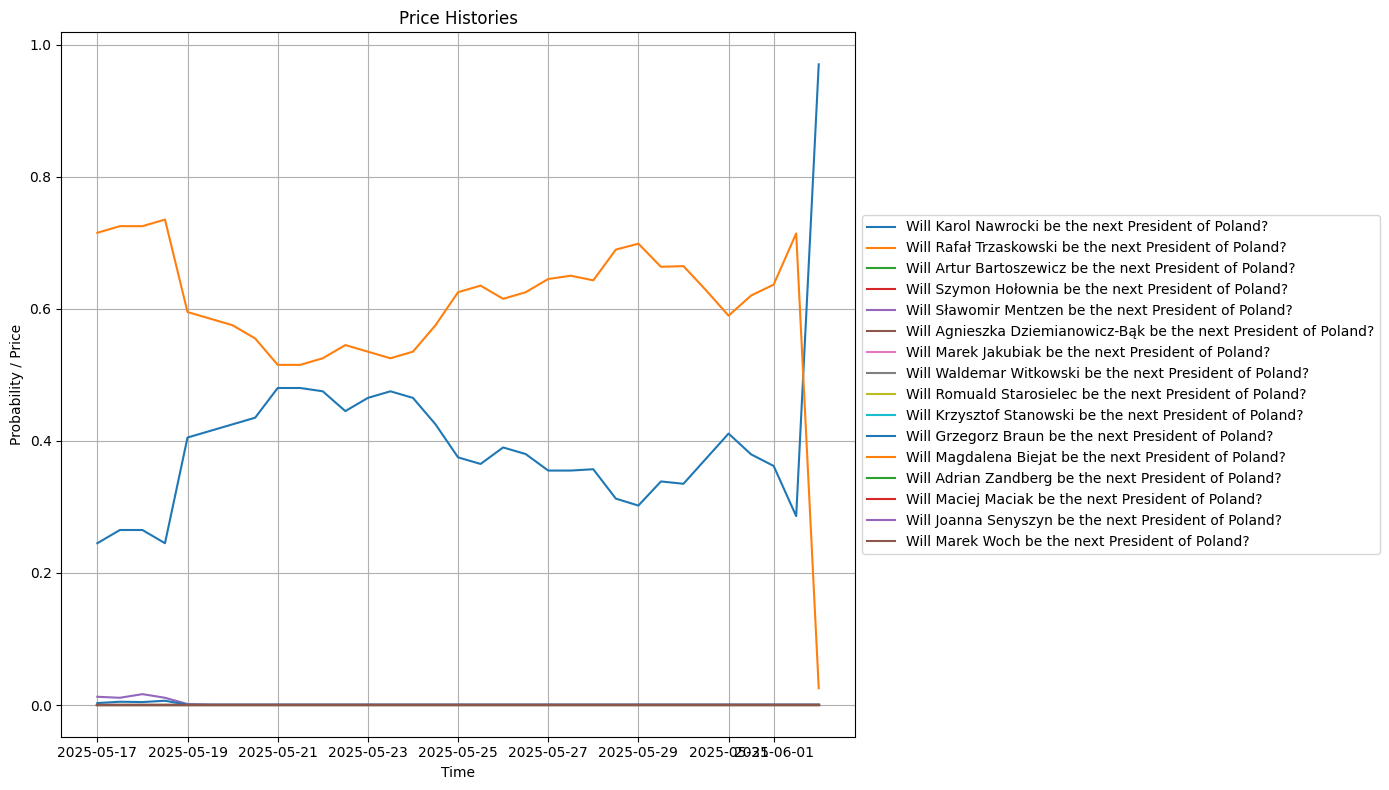

In [ ]:
FIDELITY = 720
EVENT_URL = "https://polymarket.com/event/poland-presidential-election"
token_mapping = fetch_market_token_mapping(event_url=EVENT_URL)
print(token_mapping)
plot_multiple_markets(token_mapping=token_mapping, fidelity=FIDELITY)

Gives a table with where the column is the title e.g. "Will Donald Trump win the 2024 US Presidentail Election" (title of the market)

For the Row it uses the timestamp

In [ ]:
def fetch_and_merge_price_histories(token_mapping: dict, fidelity: int = 720):
    dfs = []
    for label, token_id in token_mapping.items():
        price_data = get_prices(token_id, fidelity)
        hist = price_data.get("history", [])
        if not hist:
            print(f"Warning: no history for {label!r}, skipping.")
            continue

        df = pd.DataFrame(hist)               # columns: ['t','p']
        df["time"] = pd.to_datetime(df["t"], unit="s")
        df = df.set_index("time").rename(columns={"p": label}).drop(columns=["t"])
        dfs.append(df)

    # inner‐join on timestamps
    df_merged = dfs[0]
    for df in dfs[1:]:
        df_merged = df_merged.join(df, how="inner")

    if df_merged.empty:
        raise RuntimeError("No overlapping timestamps between markets.")
    return df_merged


In [ ]:
token_mapping = fetch_market_token_mapping(event_url=EVENT_URL)
fetch_and_merge_price_histories(token_mapping=token_mapping, fidelity=FIDELITY)

,Will Karol Nawrocki be the next President of Poland?,Will Rafał Trzaskowski be the next President of Poland?,Will Artur Bartoszewicz be the next President of Poland?,Will Szymon Hołownia be the next President of Poland?,Will Sławomir Mentzen be the next President of Poland?,Will Agnieszka Dziemianowicz-Bąk be the next President of Poland?,Will Marek Jakubiak be the next President of Poland?,Will Waldemar Witkowski be the next President of Poland?,Will Romuald Starosielec be the next President of Poland?,Will Krzysztof Stanowski be the next President of Poland?,Will Grzegorz Braun be the next President of Poland?,Will Magdalena Biejat be the next President of Poland?,Will Adrian Zandberg be the next President of Poland?,Will Maciej Maciak be the next President of Poland?,Will Joanna Senyszyn be the next President of Poland?,Will Marek Woch be the next President of Poland?
time,,,,,,,,,,,,,,,,
2025-05-17 00:00:07,0.2450,0.7150,0.0005,0.0005,0.0125,0.0005,0.0005,0.0005,0.0005,0.0005,0.0030,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-17 12:00:06,0.2650,0.7250,0.0005,0.0005,0.0110,0.0005,0.0005,0.0005,0.0005,0.0005,0.0050,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-18 00:00:06,0.2650,0.7250,0.0005,0.0005,0.0165,0.0005,0.0005,0.0005,0.0005,0.0005,0.0045,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-18 12:00:07,0.2450,0.7350,0.0005,0.0005,0.0110,0.0005,0.0005,0.0005,0.0005,0.0005,0.0065,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-19 00:00:06,0.4050,0.5950,0.0005,0.0005,0.0015,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-19 12:00:05,0.4150,0.5850,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-20 00:00:06,0.4250,0.5750,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-20 12:00:07,0.4350,0.5550,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
2025-05-21 00:00:06,0.4800,0.5150,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005


In [ ]:
def get_only_selected_columns(df_table, columns=None):
  if not (columns == None):
    return(df_table[columns])
  else:
    return df_table


## Selecting which markets to pick - to analyse

In [ ]:
# COLUMN_NAMES_TO_PICK = ['Will Donald Trump win the 2024 US Presidential Election?']
# COLUMN_NAMES_TO_PICK = ['Will Waldemar Witkowski be the next President of Poland?']
# None - selects every market in that event

COLUMN_NAMES_TO_PICK = None

In [ ]:
df_prices = fetch_and_merge_price_histories(token_mapping, fidelity=720)
# print("Only selected columns: ", get_only_selected_columns(df_prices, ['Will Donald Trump win the 2024 US Presidential Election?']))
df_prices = get_only_selected_columns(df_prices, COLUMN_NAMES_TO_PICK)

# 2.1 Melt
df_long = (
    df_prices
    .reset_index()                                 # bring time back as a column
    .melt(id_vars="time", var_name="market", value_name="p_t")
    .dropna(subset=["p_t"])                        # drop any NA-snapshots
)

# 2.2 Sort & index
df_long = df_long.sort_values(["market","time"]).reset_index(drop=True)
print(df_long)
df_long["i"] = df_long.groupby("market").cumcount() + 1

# 2.3 Compute previous price p_{i-1}
df_long["p_prev"] = df_long.groupby("market")["p_t"].shift(1)
df_long = df_long.dropna(subset=["p_prev"])        # drop each market’s very first row
df_long["i"] = df_long.groupby("market").cumcount()+1  # re-index now that we've dropped

                   time                                             market  \
0   2025-05-17 00:00:07  Will Adrian Zandberg be the next President of ...   
1   2025-05-17 12:00:06  Will Adrian Zandberg be the next President of ...   
2   2025-05-18 00:00:06  Will Adrian Zandberg be the next President of ...   
3   2025-05-18 12:00:07  Will Adrian Zandberg be the next President of ...   
4   2025-05-19 00:00:06  Will Adrian Zandberg be the next President of ...   
..                  ...                                                ...   
523 2025-05-31 00:00:07  Will Waldemar Witkowski be the next President ...   
524 2025-05-31 12:00:07  Will Waldemar Witkowski be the next President ...   
525 2025-06-01 00:00:07  Will Waldemar Witkowski be the next President ...   
526 2025-06-01 12:00:07  Will Waldemar Witkowski be the next President ...   
527 2025-06-02 00:00:06  Will Waldemar Witkowski be the next President ...   

        p_t  
0    0.0005  
1    0.0005  
2    0.0005  
3    0.

Compute Belief

In [ ]:
def compute_belief(p0, p1):
    if p1 > p0:
        return (p1 - p0) / (1 - p0)
    else:
        return (p0 - p1) / p0

df_long["b_i"] = df_long.apply(lambda r: compute_belief(r.p_prev, r.p_t), axis=1)


In [ ]:
df_long["cum_max_b"] = df_long.groupby("market")["b_i"].cummax()
df_long["cum_min_b"] = df_long.groupby("market")["b_i"].cummin()
df_long["delta_b"]   = df_long["cum_max_b"] - df_long["cum_min_b"]

## Here add to the parameters which events to consider (Will DT win? Will kamala win?)

In [ ]:
df_prices = fetch_and_merge_price_histories(token_mapping, fidelity=720)
# df_prices = get_only_selected_columns(df_prices, ['Will Donald Trump win the 2024 US Presidential Election?'])
# df_prices = get_only_selected_columns(df_prices, ['Will Joe Biden win the 2024 US Presidential Election?', 'Will Donald Trump win the 2024 US Presidential Election?', 'Will Kamala Harris win the 2024 US Presidential Election?', 'Will Kanye West win the 2024 US Presidential Election?'])
df_prices = get_only_selected_columns(df_prices, COLUMN_NAMES_TO_PICK)


# 2.1 Melt
df_long = (
    df_prices
    .reset_index()                                 # bring time back as a column
    .melt(id_vars="time", var_name="market", value_name="p_t")
    .dropna(subset=["p_t"])                        # drop any NA-snapshots
)

# 2.2 Sort & index
df_long = df_long.sort_values(["market","time"]).reset_index(drop=True)
df_long["i"] = df_long.groupby("market").cumcount() + 1

# 2.3 Compute previous price p_{i-1}
df_long["p_prev"] = df_long.groupby("market")["p_t"].shift(1)
df_long = df_long.dropna(subset=["p_prev"])        # drop each market’s very first row
df_long["i"] = df_long.groupby("market").cumcount()+1  # re-index now that we've dropped

In [ ]:
def compute_belief(p0, p1):
    if p1 > p0:
        return (p1 - p0) / (1 - p0)
    else:
        return (p0 - p1) / p0

df_long["b_i"] = df_long.apply(lambda r: compute_belief(r.p_prev, r.p_t), axis=1)


In [ ]:
df_long["cum_max_b"] = df_long.groupby("market")["b_i"].cummax()
df_long["cum_min_b"] = df_long.groupby("market")["b_i"].cummin()
df_long["delta_b"]   = df_long["cum_max_b"] - df_long["cum_min_b"]

# print(df_long["cum_max_b"])
# print(df_long["cum_min_b"])
# print(df_long["delta_b"])

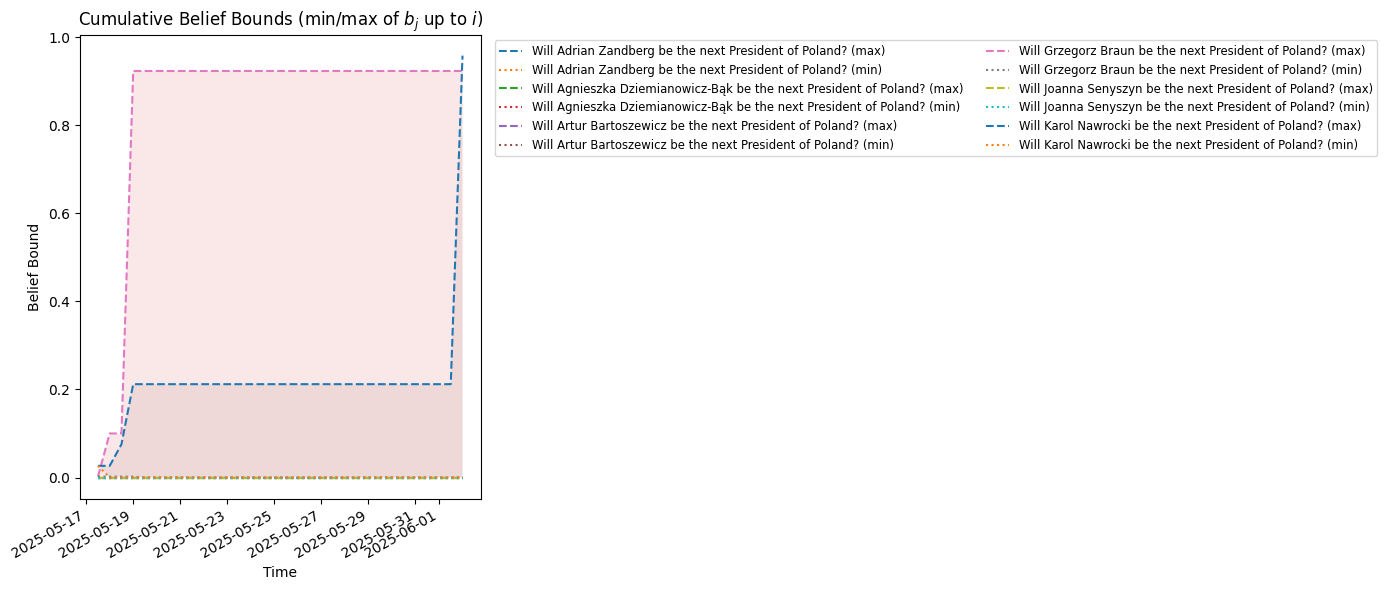

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# 1) Choose 4–6 representative markets to avoid overplotting
markets_to_plot = df_long['market'].unique()[:6]

fig, ax = plt.subplots(figsize=(14, 6))

for m in markets_to_plot:
    grp = df_long[df_long['market'] == m]
    # Plot the upper and lower cumulative bounds
    ax.plot(grp['time'], grp['cum_max_b'], linestyle='--', label=f"{m} (max)")
    ax.plot(grp['time'], grp['cum_min_b'], linestyle=':', label=f"{m} (min)")
    # Shade the area between them
    ax.fill_between(
        grp['time'],
        grp['cum_min_b'],
        grp['cum_max_b'],
        alpha=0.1
    )

# 2) Format x-axis nicely
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# 3) Labels & legend
ax.set_title("Cumulative Belief Bounds (min/max of $b_j$ up to $i$)")
ax.set_xlabel("Time")
ax.set_ylabel("Belief Bound")
ax.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


Compute & Plot the Rolling Belief-Spread

1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
523    0.0
524    0.0
525    0.0
526    0.0
527    0.0
Name: delta_b_roll, Length: 512, dtype: float64


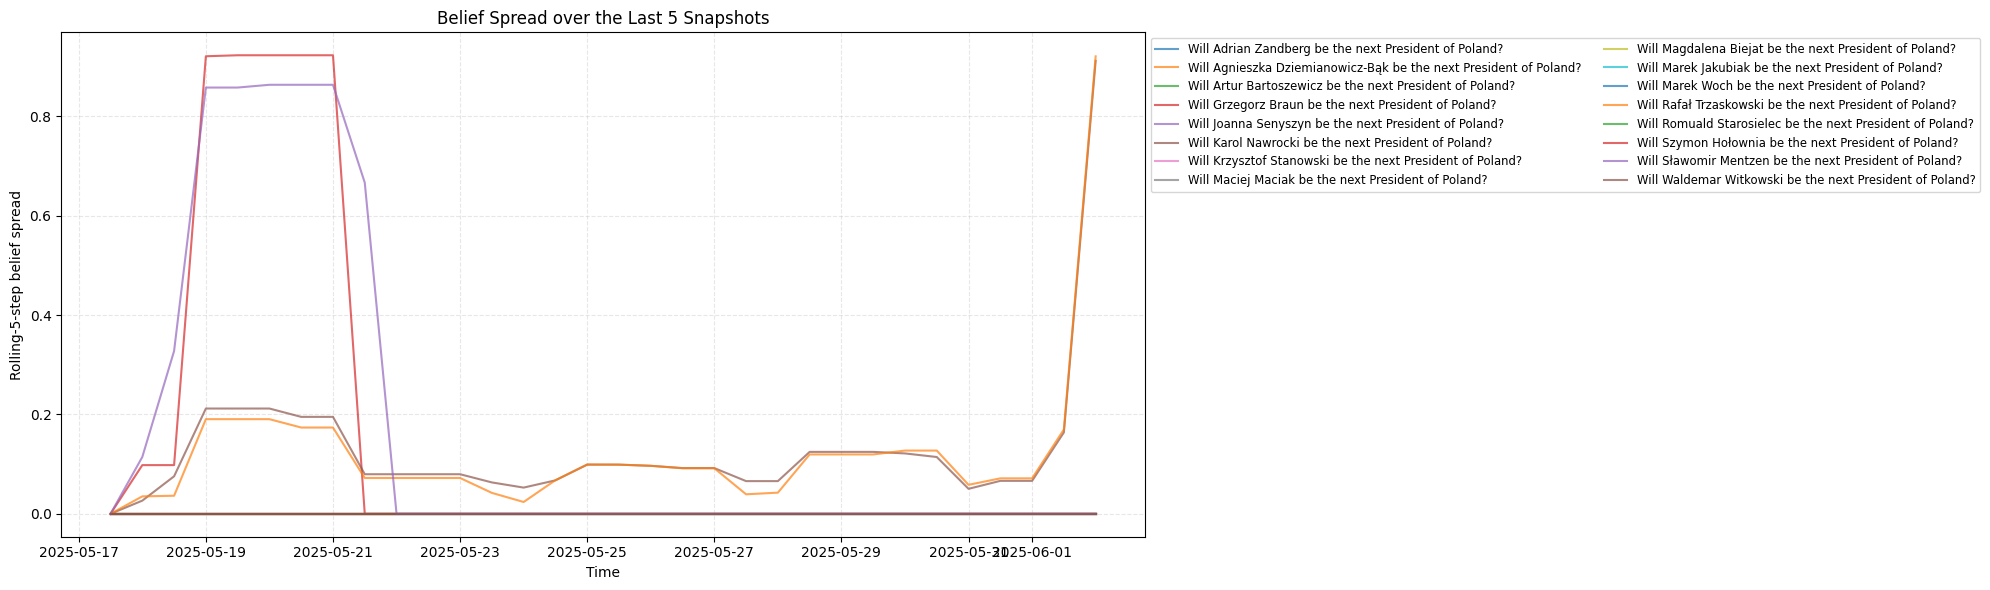

In [ ]:
import matplotlib.pyplot as plt

# --- 1) choose your window (number of snapshots) ---
W = 5

# --- 2) rolling max/min & spread ---
df_long["b_roll_max"] = (
    df_long
    .groupby("market")["b_i"]
    .transform(lambda x: x.rolling(W, min_periods=1).max())
)
df_long["b_roll_min"] = (
    df_long
    .groupby("market")["b_i"]
    .transform(lambda x: x.rolling(W, min_periods=1).min())
)
df_long["delta_b_roll"] = df_long["b_roll_max"] - df_long["b_roll_min"]
print(df_long["delta_b_roll"])
# --- 3) plot ---
plt.figure(figsize=(20,6))
for m, grp in df_long.groupby("market"):
    plt.plot(
        grp["time"],
        grp["delta_b_roll"],
        label=m,
        alpha=0.7
    )

plt.xlabel("Time")
plt.ylabel(f"Rolling-{W}-step belief spread")
plt.title(f"Belief Spread over the Last {W} Snapshots")
plt.legend(fontsize="small", ncol=2, bbox_to_anchor=(1,1))
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Descption using the rolling window

## First entry always has a 0 at the beging that why the metrics did fail. Updated version where this case it taken into consideration

Handle the zero row(s)

Key Metrics: What They Mean

    Threshold-Hit Iδ: “How many trades until the market’s recent disagreement is small (≤δ)?” A smaller Iδ means you reach consensus faster.

    Half-life i₁/₂: “How many trades until beliefs have tightened by half?” Analogous to a radioactive half-life—shorter means rapid convergence.

    Decay Rate λ: “On each trade, the spread shrinks by roughly a factor e⁻ᶦ·`. A larger λ means exponential convergence; λ≈0 means nearly no systematic decay.

    R² (from the decay fit): how well that simple exponential law describes the actual data (near 0 → very noisy or non-exponential).

Why These Matter

By combining the rolling-spread curves with Iδ, i₁/₂, and λ, we get both a visual and quantitative sense of:

    Timing: when markets stop diverging (threshold hits, half-lives).

    Speed: how fast they knit back together after shocks (decay rates).

    Amplitude: how big their disagreements ever get (peak Δb_roll).

Together, these tell us which markets converge quickly (tight, early spreads) vs. linger in disagreement—and help us link that behavior to real-world events or design choices (liquidity, trade frequency, news arrival).

In [ ]:
# For each market, record the first snapshot i where rolling spread > 0
first_nonzero = {
    market: int(grp.loc[grp["delta_b_roll"] > 0, "i"].min())
    if (grp["delta_b_roll"] > 0).any()
    else None
    for market, grp in df_long.groupby("market")
}


Threshold-Hit Indices Iδ

In [ ]:
thresholds = [0.02, 0.01]
thresh_rows = []

for market, grp in df_long.groupby("market"):
    i0 = first_nonzero[market]
    for δ in thresholds:
        if i0 is None:
            i_hit, t_hit = None, None
        else:
            mask = (grp["i"] >= i0) & (grp["delta_b_roll"] <= δ)
            if mask.any():
                i_hit = int(grp.loc[mask, "i"].min())
                t_hit = grp.loc[grp["i"] == i_hit, "time"].iloc[0]
            else:
                i_hit, t_hit = None, None

        thresh_rows.append({
            "market": market,
            "threshold": δ,
            "I_delta": i_hit,
            "time_I_delta": t_hit
        })

df_thresh = pd.DataFrame(thresh_rows)
print("\n=== Threshold Hits ===")
print(df_thresh)



=== Threshold Hits ===
                                               market  threshold  I_delta  \
0   Will Adrian Zandberg be the next President of ...       0.02      NaN   
1   Will Adrian Zandberg be the next President of ...       0.01      NaN   
2   Will Agnieszka Dziemianowicz-Bąk be the next P...       0.02      NaN   
3   Will Agnieszka Dziemianowicz-Bąk be the next P...       0.01      NaN   
4   Will Artur Bartoszewicz be the next President ...       0.02      NaN   
5   Will Artur Bartoszewicz be the next President ...       0.01      NaN   
6   Will Grzegorz Braun be the next President of P...       0.02      9.0   
7   Will Grzegorz Braun be the next President of P...       0.01      9.0   
8   Will Joanna Senyszyn be the next President of ...       0.02      NaN   
9   Will Joanna Senyszyn be the next President of ...       0.01      NaN   
10  Will Karol Nawrocki be the next President of P...       0.02      NaN   
11  Will Karol Nawrocki be the next President of P..

Half Life

In [ ]:
half_rows = []

for market, grp in df_long.groupby("market"):
    i0 = first_nonzero[market]
    if i0 is None:
        half_rows.append({
            "market": market,
            "initial_delta": None,
            "half_value": None,
            "i_half": None,
            "time_half": None
        })
        continue

    # Initial spread is at the first nonzero index, not at i=1
    initial = grp.loc[grp["i"] == i0, "delta_b_roll"].iloc[0]
    half_val = 0.5 * initial

    mask = (grp["i"] >= i0) & (grp["delta_b_roll"] <= half_val)
    if mask.any():
        i_half = int(grp.loc[mask, "i"].min())
        t_half = grp.loc[grp["i"] == i_half, "time"].iloc[0]
    else:
        i_half, t_half = None, None

    half_rows.append({
        "market": market,
        "initial_delta": initial,
        "half_value": half_val,
        "i_half": i_half,
        "time_half": t_half
    })

df_half = pd.DataFrame(half_rows)
print("\n=== Half-Life ===")
print(df_half)



=== Half-Life ===
                                               market  initial_delta  \
0   Will Adrian Zandberg be the next President of ...            NaN   
1   Will Agnieszka Dziemianowicz-Bąk be the next P...            NaN   
2   Will Artur Bartoszewicz be the next President ...            NaN   
3   Will Grzegorz Braun be the next President of P...       0.097994   
4   Will Joanna Senyszyn be the next President of ...            NaN   
5   Will Karol Nawrocki be the next President of P...       0.026490   
6   Will Krzysztof Stanowski be the next President...            NaN   
7   Will Maciej Maciak be the next President of Po...            NaN   
8   Will Magdalena Biejat be the next President of...            NaN   
9   Will Marek Jakubiak be the next President of P...            NaN   
10   Will Marek Woch be the next President of Poland?            NaN   
11  Will Rafał Trzaskowski be the next President o...       0.035088   
12  Will Romuald Starosielec be the next Pres

Decay Rate

In [ ]:
import numpy as np
import statsmodels.api as sm

decay_rows = []

for market, grp in df_long.groupby("market"):
    i0 = first_nonzero[market]
    if i0 is None:
        decay_rows.append({"market": market, "lambda": None, "r2": None})
        continue

    # Use only snapshots from i0 onward, with positive spread
    sub = grp.loc[(grp["i"] >= i0) & (grp["delta_b_roll"] > 0)].copy()
    if len(sub) < 5:
        decay_rows.append({"market": market, "lambda": None, "r2": None})
        continue

    # Regress ln(spread) on snapshot index
    X = sm.add_constant(sub["i"])
    Y = np.log(sub["delta_b_roll"])
    model = sm.OLS(Y, X).fit()
    λ = -model.params["i"]
    decay_rows.append({
        "market": market,
        "lambda": λ,
        "r2": model.rsquared
    })

df_decay = pd.DataFrame(decay_rows)
print("\n=== Decay Rates ===")
print(df_decay)



=== Decay Rates ===
                                               market    lambda        r2
0   Will Adrian Zandberg be the next President of ...       NaN       NaN
1   Will Agnieszka Dziemianowicz-Bąk be the next P...       NaN       NaN
2   Will Artur Bartoszewicz be the next President ...       NaN       NaN
3   Will Grzegorz Braun be the next President of P... -0.400579  0.625485
4   Will Joanna Senyszyn be the next President of ...       NaN       NaN
5   Will Karol Nawrocki be the next President of P... -0.008199  0.014001
6   Will Krzysztof Stanowski be the next President...       NaN       NaN
7   Will Maciej Maciak be the next President of Po...       NaN       NaN
8   Will Magdalena Biejat be the next President of...       NaN       NaN
9   Will Marek Jakubiak be the next President of P...       NaN       NaN
10   Will Marek Woch be the next President of Poland?       NaN       NaN
11  Will Rafał Trzaskowski be the next President o... -0.015903  0.042578
12  Will Romuald 

Combinig to one summary

In [ ]:
# Merge threshold (for δ=0.02 only), half-life, and decay into a single table
df_summary = (
    df_thresh.query("threshold == 0.02")[["market","I_delta","time_I_delta"]]
    .merge(df_half[["market","i_half","time_half"]], on="market")
    .merge(df_decay, on="market")
)
print("\n=== Summary ===")
print(df_summary)



=== Summary ===
                                               market  I_delta  \
0   Will Adrian Zandberg be the next President of ...      NaN   
1   Will Agnieszka Dziemianowicz-Bąk be the next P...      NaN   
2   Will Artur Bartoszewicz be the next President ...      NaN   
3   Will Grzegorz Braun be the next President of P...      9.0   
4   Will Joanna Senyszyn be the next President of ...      NaN   
5   Will Karol Nawrocki be the next President of P...      NaN   
6   Will Krzysztof Stanowski be the next President...      NaN   
7   Will Maciej Maciak be the next President of Po...      NaN   
8   Will Magdalena Biejat be the next President of...      NaN   
9   Will Marek Jakubiak be the next President of P...      NaN   
10   Will Marek Woch be the next President of Poland?      NaN   
11  Will Rafał Trzaskowski be the next President o...      NaN   
12  Will Romuald Starosielec be the next President...      NaN   
13  Will Szymon Hołownia be the next President of ...      

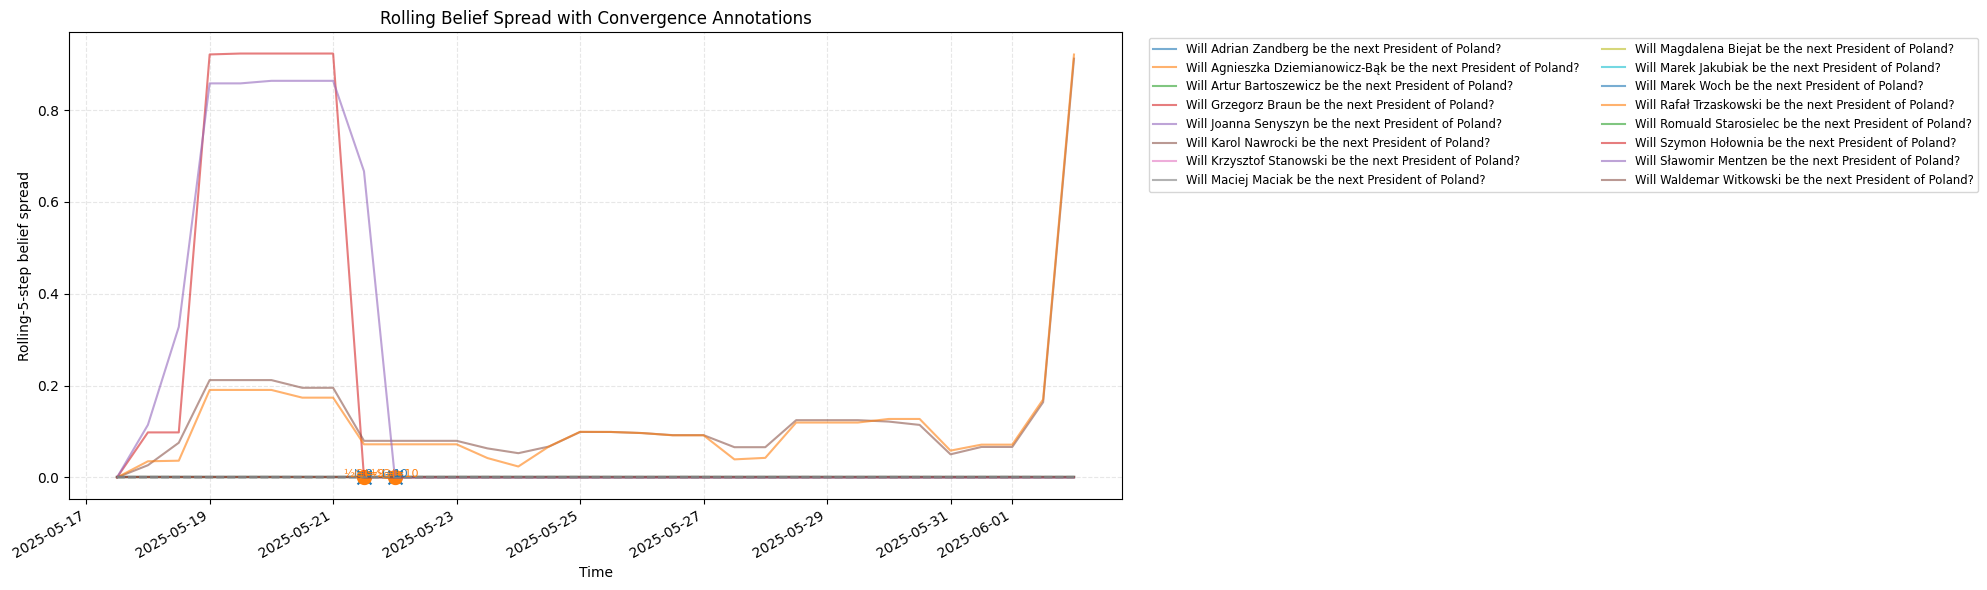

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Pick the markets you actually have rolling‐spread for
markets_to_plot = df_long['market'].unique()

fig, ax = plt.subplots(figsize=(20,6))

# 1) Plot rolling spread for each market
for m in markets_to_plot:
    grp = df_long[df_long['market'] == m]
    ax.plot(grp['time'], grp['delta_b_roll'], label=m, alpha=0.6)

# 2) Annotate metrics
for m in markets_to_plot:
    # --- Threshold I_{0.02} ---
    thr_row = df_thresh[(df_thresh.market == m) & (df_thresh.threshold == 0.02)]
    if not thr_row.empty and pd.notna(thr_row.iloc[0]['I_delta']):
        i_delta = int(thr_row.iloc[0]['I_delta'])
        t_delta = thr_row.iloc[0]['time_I_delta']
        val_delta = df_long[(df_long.market==m) & (df_long.i==i_delta)]['delta_b_roll'].iloc[0]

        ax.scatter(t_delta, val_delta,
                   color='C0', marker='x', s=100)
        ax.text(t_delta, val_delta * 1.05,
                f"I={i_delta}", color='C0', fontsize=8, ha='center')

    # --- Half‐life ---
    hl_row = df_half[df_half.market == m]
    if not hl_row.empty and pd.notna(hl_row.iloc[0]['i_half']):
        i_half = int(hl_row.iloc[0]['i_half'])
        t_half = hl_row.iloc[0]['time_half']
        val_half = df_long[(df_long.market==m) & (df_long.i==i_half)]['delta_b_roll'].iloc[0]

        ax.scatter(t_half, val_half,
                   color='C1', marker='o', s=100)
        ax.text(t_half, val_half * 0.95,
                f"½@i={i_half}", color='C1', fontsize=8, ha='center')

    # --- Decay fit (optional) ---
    dec_row = df_decay[df_decay.market == m]
    if not dec_row.empty and pd.notna(dec_row.iloc[0]['lambda']):
        λ = dec_row.iloc[0]['lambda']
        grp_fit = df_long[df_long['market']==m]
        X = grp_fit['i']
        # compute alpha so that y_fit starts at actual first value
        first_delta = grp_fit['delta_b_roll'].iloc[0]
        alpha = np.log(first_delta + 1e-9) + λ * grp_fit['i'].iloc[0]
        y_fit = np.exp(alpha - λ * X)

        ax.plot(grp_fit['time'], y_fit,
                linestyle='--', color='gray', alpha=0.7)

# 3) Final formatting
ax.set_xlabel("Time")
ax.set_ylabel(f"Rolling-{W}-step belief spread")
ax.set_title("Rolling Belief Spread with Convergence Annotations")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Consolidate legend entries (one per line)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          fontsize="small", ncol=2,
          bbox_to_anchor=(1.02,1), loc="upper left")

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Area under the curve (AUC) - the samller the better less beliefs are being updated

In [ ]:
auc_rows = []
for market, grp in df_long.groupby("market"):
    # only after first nonzero i0
    i0 = first_nonzero[market]
    sub = grp[grp["i"] >= i0]
    if len(sub) < 2:
        auc = None
    else:
        # integrate delta_b_roll vs i
        i_vals = sub["i"].values
        d_vals = sub["delta_b_roll"].values
        auc = np.trapz(d_vals, x=i_vals)
    auc_rows.append({"market": market, "AUC": auc})

df_auc = pd.DataFrame(auc_rows).sort_values("AUC")
print(df_auc)

                                               market       AUC
11  Will Rafał Trzaskowski be the next President o...  3.398721
5   Will Karol Nawrocki be the next President of P...  3.639062
3   Will Grzegorz Braun be the next President of P...  4.760370
14  Will Sławomir Mentzen be the next President of...  5.358718
0   Will Adrian Zandberg be the next President of ...       NaN
1   Will Agnieszka Dziemianowicz-Bąk be the next P...       NaN
2   Will Artur Bartoszewicz be the next President ...       NaN
4   Will Joanna Senyszyn be the next President of ...       NaN
6   Will Krzysztof Stanowski be the next President...       NaN
7   Will Maciej Maciak be the next President of Po...       NaN
8   Will Magdalena Biejat be the next President of...       NaN
9   Will Marek Jakubiak be the next President of P...       NaN
10   Will Marek Woch be the next President of Poland?       NaN
12  Will Romuald Starosielec be the next President...       NaN
13  Will Szymon Hołownia be the next Pre

<ipython-input-72-4a0f7af14412>:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(d_vals, x=i_vals)


## Description using the cumulative belief update - Don't think this is very insightful


In [ ]:
thresholds = [0.02, 0.01]
hits = []
for m, grp in df_long.groupby("market"):
    for δ in thresholds:
        mask = grp["delta_b"] <= δ
        if mask.any():
            i_hit = int(grp.loc[mask,"i"].min())
            t_hit = grp.loc[grp["i"]==i_hit,"time"].iloc[0]
        else:
            i_hit, t_hit = None, None
        hits.append({"market":m, "delta":δ, "I_delta":i_hit, "time_I_delta":t_hit})

df_I = pd.DataFrame(hits)
df_I.to_csv("I_delta.csv", index=False)


In [ ]:
# initial spread per market:
first = (df_long[df_long["i"]==1]
         .loc[:,["market","delta_b"]]
         .rename(columns={"delta_b":"delta1"}))

df = df_long.merge(first, on="market", how="left")
df["half_val"] = 0.5 * df["delta1"]

halves = []
for m, grp in df.groupby("market"):
    mask = grp["delta_b"] <= grp["half_val"].iloc[0]
    if mask.any():
        i_h = int(grp.loc[mask,"i"].min())
        t_h = grp.loc[grp["i"]==i_h,"time"].iloc[0]
    else:
        i_h, t_h = None, None
    halves.append({"market":m, "i_half":i_h, "time_half":t_h})

df_half = pd.DataFrame(halves)
df_half.to_csv("half_life.csv", index=False)

In [ ]:
import numpy as np, statsmodels.api as sm

decays = []
for m, grp in df_long.groupby("market"):
    sub = grp[grp["delta_b"]>0]
    if len(sub)<10:
        decays.append({"market":m, "lambda":None, "r2":None})
        continue

    X = sm.add_constant(sub["i"])
    Y = np.log(sub["delta_b"])
    mdl = sm.OLS(Y, X).fit()
    decays.append({
        "market": m,
        "lambda": -mdl.params["i"],
        "r2": mdl.rsquared
    })

df_lambda = pd.DataFrame(decays)
df_lambda.to_csv("decay_rates.csv", index=False)


## Extract convergence metrics:

In [ ]:
thresholds = [0.02, 0.01]
hits = []
for m, grp in df_long.groupby("market"):
    for δ in thresholds:
        mask = grp["delta_b"] <= δ
        if mask.any():
            i_hit = int(grp.loc[mask,"i"].min())
            t_hit = grp.loc[grp["i"]==i_hit,"time"].iloc[0]
        else:
            i_hit, t_hit = None, None
        hits.append({"market":m, "delta":δ, "I_delta":i_hit, "time_I_delta":t_hit})

df_I = pd.DataFrame(hits)
df_I.to_csv("I_delta.csv", index=False)


## Half-life

In [ ]:
# initial spread per market:
first = (df_long[df_long["i"]==1]
         .loc[:,["market","delta_b"]]
         .rename(columns={"delta_b":"delta1"}))

df = df_long.merge(first, on="market", how="left")
df["half_val"] = 0.5 * df["delta1"]

halves = []
for m, grp in df.groupby("market"):
    mask = grp["delta_b"] <= grp["half_val"].iloc[0]
    if mask.any():
        i_h = int(grp.loc[mask,"i"].min())
        t_h = grp.loc[grp["i"]==i_h,"time"].iloc[0]
    else:
        i_h, t_h = None, None
    halves.append({"market":m, "i_half":i_h, "time_half":t_h})

df_half = pd.DataFrame(halves)
df_half.to_csv("half_life.csv", index=False)

## Decay-rate

In [ ]:
import numpy as np, statsmodels.api as sm

decays = []
for m, grp in df_long.groupby("market"):
    sub = grp[grp["delta_b"]>0]
    if len(sub)<10:
        decays.append({"market":m, "lambda":None, "r2":None})
        continue

    X = sm.add_constant(sub["i"])
    Y = np.log(sub["delta_b"])
    mdl = sm.OLS(Y, X).fit()
    decays.append({
        "market": m,
        "lambda": -mdl.params["i"],
        "r2": mdl.rsquared
    })

df_lambda = pd.DataFrame(decays)
df_lambda.to_csv("decay_rates.csv", index=False)
